In [1]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from rasterio.plot import show
from numpy import asarray
from numpy import save

In [2]:
def read_data(inras):
    # Read data
    img = gdal.Open(inras, gdal.GA_ReadOnly) 
    bands = [img.GetRasterBand(i).ReadAsArray() for i in range(1, img.RasterCount + 1)]
    img = np.array(bands) # numpy array [band, row, col]
    
    # # or with rasterio
    # import rasterio
    # with rasterio.open(img_path, 'r') as ds:
    #     img = ds.read()  # read all raster values
    
    img = img[0:12,:,:] # 12 spectral bands
    img = np.transpose(img, [1, 2, 0]) # numpy array [row, col, bands]
    #img = img[np.logical_not(np.isnan(img))]
    
    #print(img.shape)
    
    # B2-->Blue
    # B3-->Green
    # B4-->Red
    # Bx-->NIR

    # remember the indexes in NumPy arrays start with 0 --> bands begin from 0!

    img_rgb = img[:,:,[3,2,1]]
    #print(img_rgb.shape)

    def MyNormalize(img_i,sigma):
        nr,nc,nb = img_i.shape
        img_n = np.zeros(shape=(nr,nc,nb))
        for i in range(0,nb):
            one_band = img_i[:,:,i]
            mi = np.min(one_band)
            ma = np.max(one_band)
            one_band = (one_band-mi)/(ma-mi+np.finfo(float).eps)
            img_n[:,:,i] = sigma*one_band
        return img_n

    return img_rgb

In [3]:
# Opening and Closing by Reconstruction
from skimage.morphology import reconstruction
from skimage.morphology import erosion
from skimage.morphology import disk
from skimage import util

def opening_by_reconstruction(image, se):
    """
        Performs an Opening by Reconstruction.

        Parameters:
            image: 2D matrix.
            se: structuring element
        Returns:
            2D matrix of the reconstructed image.
    """
    eroded = erosion(image, se)
    reconstructed = reconstruction(eroded, image)
    return reconstructed


def closing_by_reconstruction(image, se):
    """
        Performs a Closing by Reconstruction.

        Parameters:
            image: 2D matrix.
            se: structuring element
        Returns:
            2D matrix of the reconstructed image.
    """
    obr = opening_by_reconstruction(image, se)

    obr_inverted = util.invert(obr)
    obr_inverted_eroded = erosion(obr_inverted, se)
    obr_inverted_eroded_rec = reconstruction(
        obr_inverted_eroded, obr_inverted)
    obr_inverted_eroded_rec_inverted = util.invert(obr_inverted_eroded_rec)
    return obr_inverted_eroded_rec_inverted

def build_morphological_profiles(image, se_size=4, se_size_increment=2, num_openings_closings=4):
    """
        Build the morphological profiles for a given image.

        Parameters:
            base_image: 2d matrix, it is the spectral information part of the MP.
            se_size: int, initial size of the structuring element (or kernel). Structuring Element used: disk
            se_size_increment: int, structuring element increment step
            num_openings_closings: int, number of openings and closings by reconstruction to perform.
        Returns: 
            emp: 3d matrix with both spectral (from the base_image) and spatial information         
    """
    x, y = image.shape

    cbr = np.zeros(shape=(x, y, num_openings_closings))
    obr = np.zeros(shape=(x, y, num_openings_closings))

    it = 0
    tam = se_size
    while it < num_openings_closings:
        se = disk(tam)
        temp = closing_by_reconstruction(image, se)
        cbr[:, :, it] = temp[:, :]
        temp = opening_by_reconstruction(image, se)
        obr[:, :, it] = temp[:, :]
        tam += se_size_increment
        it += 1

    mp = np.zeros(shape=(x, y, (num_openings_closings*2)+1))
    cont = num_openings_closings - 1
    for i in range(num_openings_closings):
        mp[:, :, i] = cbr[:, :, cont]
        cont = cont - 1

    mp[:, :, num_openings_closings] = image[:, :]

    cont = 0
    for i in range(num_openings_closings+1, num_openings_closings*2+1):
        mp[:, :, i] = obr[:, :, cont]
        cont += 1

    return mp

def build_emp(base_image, se_size=4, se_size_increment=2, num_openings_closings=4):
    """
        Build the extended morphological profiles for a given set of images.

        Parameters:
            base_image: 3d matrix, each 'channel' is considered for applying the morphological profile. It is the spectral information part of the EMP.
            se_size: int, initial size of the structuring element (or kernel). Structuring Element used: disk
            se_size_increment: int, structuring element increment step
            num_openings_closings: int, number of openings and closings by reconstruction to perform.
        Returns:
            emp: 3d matrix with both spectral (from the base_image) and spatial information
    """
    base_image_rows, base_image_columns, base_image_channels = base_image.shape
    se_size = se_size
    se_size_increment = se_size_increment
    num_openings_closings = num_openings_closings
    morphological_profile_size = (num_openings_closings * 2) + 1
    emp_size = morphological_profile_size * base_image_channels
    emp = np.zeros(
        shape=(base_image_rows, base_image_columns, emp_size))

    cont = 0
    for i in range(base_image_channels):
        # build MPs
        mp_temp = build_morphological_profiles(
            base_image[:, :, i], se_size, se_size_increment, num_openings_closings)

        aux = morphological_profile_size * (i+1)

        # build the EMP
        cont_aux = 0
        for k in range(cont, aux):
            emp[:, :, k] = mp_temp[:, :, cont_aux]
            cont_aux += 1

        cont = morphological_profile_size * (i+1)

    return emp

def visualize(casestudy):
    fig = plt.figure(figsize=(15, 15))
    number_of_pc = 3
    columns = morphological_profile_size
    rows = number_of_pc
    print("Number of Base Images: "+str(rows))
    print("Morphological Profiles size: "+str(columns))
    print("EMP:  "+str(casestudy.shape))

    emp_size = morphological_profile_size * number_of_pc
    for i in range(1, emp_size+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(casestudy[:, :, i-1], cmap='gray', interpolation='bicubic')
        
    return plt.show()

In [3]:
#Define input rasters in list
asi = 'Input/Imagery/SingleDateImage_Amsterdam.tif'
ami = 'Input/Imagery/MedianImage_Amsterdam.tif'
msi = 'Input/Imagery/SingleDateImage_Milano.tif'
mmi = 'Input/Imagery/MedianImage_Milano.tif'
bsi = 'Input/Imagery/SingleDateImage_Budapest.tif'
bmi = 'Input/Imagery/MedianImage_Budapest.tif'
filist = [asi, ami, msi, mmi, bsi, bmi]

#define testinput rasters in list
asisub = 'Input/Imagery/Subset_SingleDateImage_Amsterdam.tif'
amisub = 'Input/Imagery/Subset_MedianImage_Amsterdam.tif'
msisub = 'Input/Imagery/Subset_SingleDateImage_Milano.tif'
mmisub = 'Input/Imagery/Subset_MedianImage_Milano.tif'
bsisub = 'Input/Imagery/Subset_SingleDateImage_Budapest.tif'
bmisub = 'Input/Imagery/Subset_MedianImage_Budapest.tif'
sublist = [asisub, amisub, msisub, mmisub, bsisub, bmisub]

In [5]:
%%time
#run emp for input list
dic1 = {}
tick = 0
for i in sublist:
    inras = i
    num_openings_closings = 4
    morphological_profile_size = (num_openings_closings * 2) + 1
    dic1[i] = build_emp(base_image=read_data(inras), num_openings_closings=num_openings_closings)
    print(tick)
    tick += 1

0
1
2
3
4
5
Wall time: 3.96 s


In [ ]:
%%time
#run emp for input list
dic = {}
tick = 0
for i in imagelist:
    inras = i
    num_openings_closings = 4
    morphological_profile_size = (num_openings_closings * 2) + 1
    dic[i] = build_emp(base_image=read_data(inras), num_openings_closings=num_openings_closings)
    print(tick)
    tick += 1

In [6]:
#check for all emp images in dictionary
for key in dic1:
    print(key)

Input/Imagery/Subset_SingleDateImage_Amsterdam.tif
Input/Imagery/Subset_MedianImage_Amsterdam.tif
Input/Imagery/Subset_SingleDateImage_Milano.tif
Input/Imagery/Subset_MedianImage_Milano.tif
Input/Imagery/Subset_SingleDateImage_Budapest.tif
Input/Imagery/Subset_MedianImage_Budapest.tif


Number of Base Images: 3
Morphological Profiles size: 9
EMP:  (201, 201, 27)


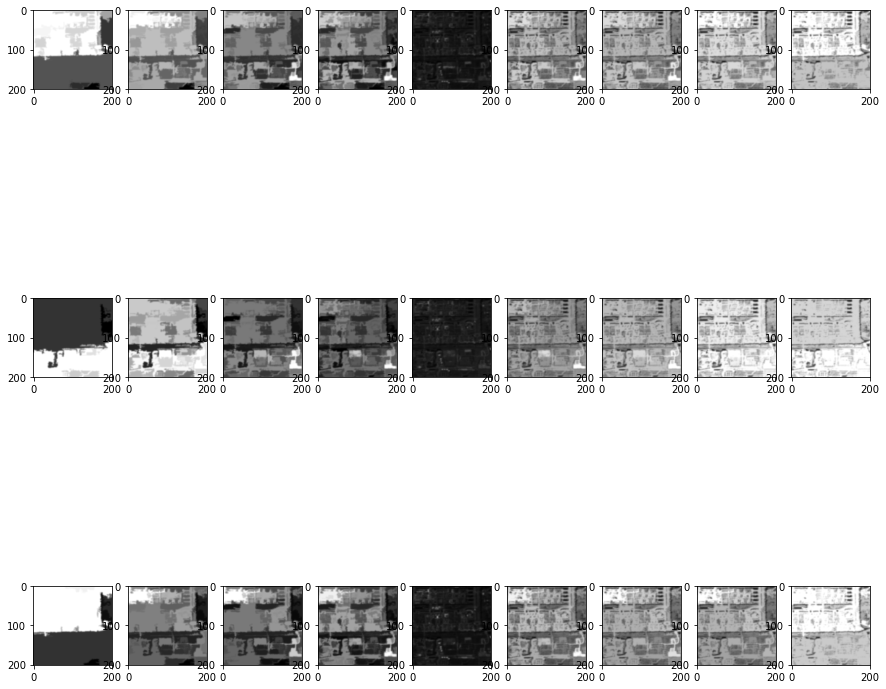

In [8]:
#visualize emp
visualize(dic1['Input/Imagery/Subset_SingleDateImage_Amsterdam.tif'])

In [12]:
save('empasi.npy', dic1['Input/Imagery/Subset_SingleDateImage_Amsterdam.tif'])
save('empami.npy', dic1['Input/Imagery/Subset_MedianImage_Amsterdam.tif'])
save('empmsi.npy', dic1['Input/Imagery/Subset_SingleDateImage_Milano.tif'])
save('empmmi.npy', dic1['Input/Imagery/Subset_MedianImage_Milano.tif'])
save('empbsi.npy', dic1['Input/Imagery/Subset_SingleDateImage_Budapest.tif'])
save('empbmi.npy', dic1['Input/Imagery/Subset_MedianImage_Budapest.tif'])